### Script to analyze NROY sets and select new ensemble members for wave 1

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import pickle

import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score


2025-02-12 16:00:41.448231: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 16:00:41.466580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739401241.485561   12968 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739401241.491162   12968 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 16:00:41.511434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [ ]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

### Setup

In [3]:
### setup
n_usets = 500 # how many to run in next wave? 

pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

out_dir = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/NROY/'

# load PPE params
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','xl','r_mort','fsr_pft']
pftix=np.array([p in pft_params for p in params.columns])

### Select Universal sets

In [6]:
# load NROY paramsets
file_list = glob.glob(os.path.join(out_dir, 'pft_laimax_NROYsets_*'))
file_list = sorted(file_list)

ds_nroy = xr.open_mfdataset(file_list,concat_dim='ens',combine='nested')

In [9]:
# Select parameters sets such that they are close to a latin hypercube sample

# flatten paramsets into factorial 
flat_psets = ds_nroy.nroy_paramsets.sel(pft=1)[:,~pftix].values
for p in pft_ids:
    p = ds_nroy.nroy_paramsets.sel(pft=p)[:,pftix].values
    flat_psets = np.concatenate((flat_psets,p),axis=1)
    
# score and select ensmble
selected_ix = sample_and_score(flat_psets,10000,n_usets,41+15*13)


In [10]:
selected_paramsets = ds_nroy.isel(ens=selected_ix)

In [11]:
filename = './params/wave1_psets_02072025.nc'
selected_paramsets.to_netcdf(filename)

### Write paramfiles

In [5]:
filename = './params/wave1_psets_02072025.nc'
selected_paramsets = xr.open_dataset(filename)

In [6]:
# convert paramset ds to numpy array
psets = np.ones((500,56,79))*0.5
for p in pft_ids:
    samp =selected_paramsets.nroy_paramsets.sel(pft=p).values
    psets[:,:,p] = samp

# create dictionary of paramsets
keys = params.columns
pset_dict = {}

u_params = params.columns.difference(pft_params) # this sorts alphabetically, watch out!
uparam_id = np.where(~pftix)[0]
for j,u in enumerate(u_params):
    pset_dict[u] = psets[:,uparam_id[j],1]
pftparam_id = np.where(pftix)[0]
for i,p in enumerate(pft_params):
    pset_dict[p] = psets[:,pftparam_id[i],:]

In [7]:
# fix some individual PFTs/params
extra_pfts = [0,9,16]
for i in range(500):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
# set c3 crops equivalent to c3 grasses
for par in pft_params:
    pset_dict[par][:,15] = pset_dict[par][:,13]

In [9]:
np.save('./params/wave1_psets_020725_pftlaimax.npy', pset_dict)

### Sanity Check

In [8]:
filename = './params/wave1_psets_02072025.nc'
selected_paramsets = xr.open_dataset(filename)

In [4]:
# load obs data
obs_data = xr.open_dataset("CLMSP_amaxLAI_2003-2015_pftmean.nc")

In [5]:
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
npfts = len(pft_ids)
emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/emulators_pftlai_amax_lhc/'
pft_names = ['not veg','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3G arctic','C3G','C4G']

In [6]:
# load PPE
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')
n_params = np.shape(params)[1]

dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_pftmean_amax_1985-2023.nc')

# drop crashers
ds_clean = ds.where(ds['crashed'] != 1, drop=True)
ix = np.where(ds.crashed==1)[0]
params_clean = params.drop(ix-1)

lai = ds_clean.TLAI_pft_amax.sel(year=slice(2003,2015)).mean(dim='year').compute()

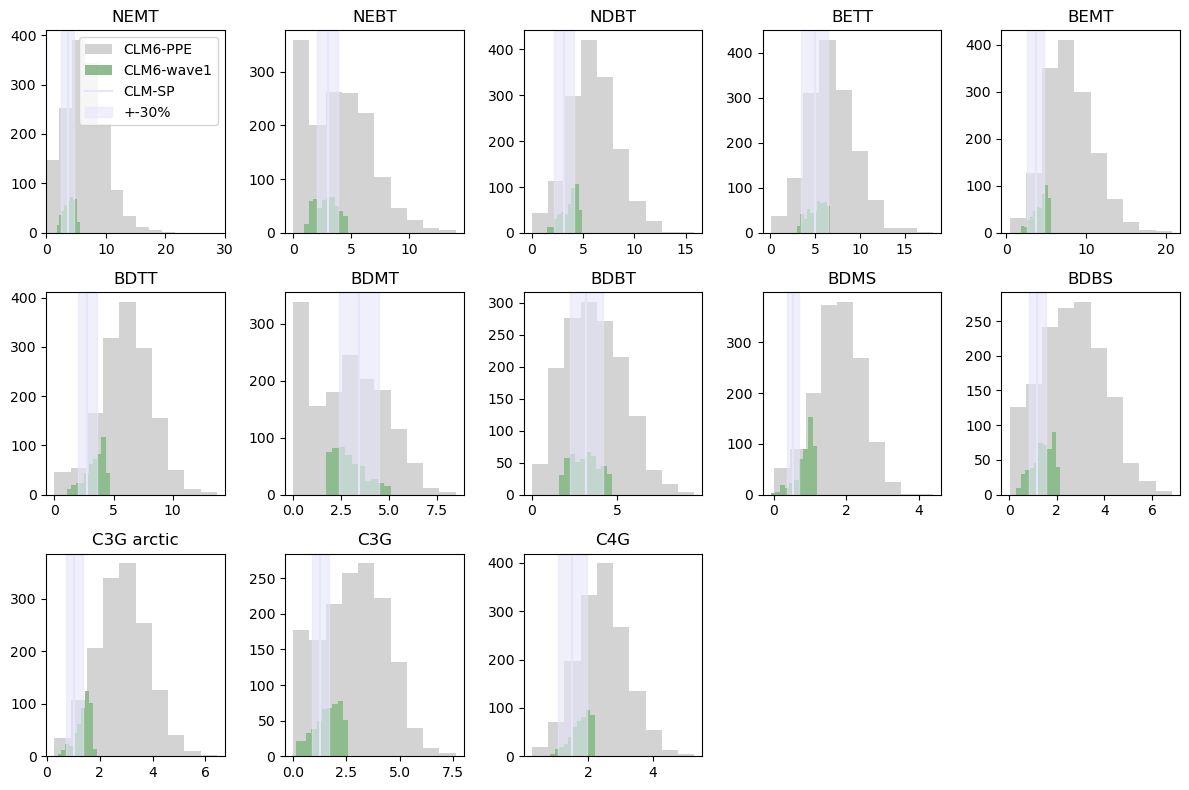

In [11]:

plt.figure(figsize=(12,8))
for p,pft in enumerate(pft_ids):

    samp = selected_paramsets.nroy_paramsets.sel(pft=pft).values

    loaded_emulator = tf.saved_model.load('/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/emulators_pftlai_amax_lhc/pft'+str(pft))
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.subplot(3,5,p+1)
    plt.hist(lai.sel(pft=pft),color='lightgrey',density=False,label='CLM6-PPE')
    plt.hist(y_pred.numpy().flatten(),color='darkseagreen',density=False,label='CLM6-wave1')
    plt.axvline(obs_data['Mean'].sel(pft=pft),color='lavender',label='CLM-SP')
    plt.axvspan(obs_data['Mean'].sel(pft=pft)-3*obs_data['StDev'].sel(pft=pft),obs_data['Mean'].sel(pft=pft)+3*obs_data['StDev'].sel(pft=pft),color='lavender',alpha = 0.6,label='+-30%')
    plt.title(pft_names[pft])

    if p==0:
        plt.legend(facecolor='white',frameon=True)
        plt.xlim([0,30])
    
plt.tight_layout()
plt.savefig('./figs/HM_wave1.png')

### Plot paramspace

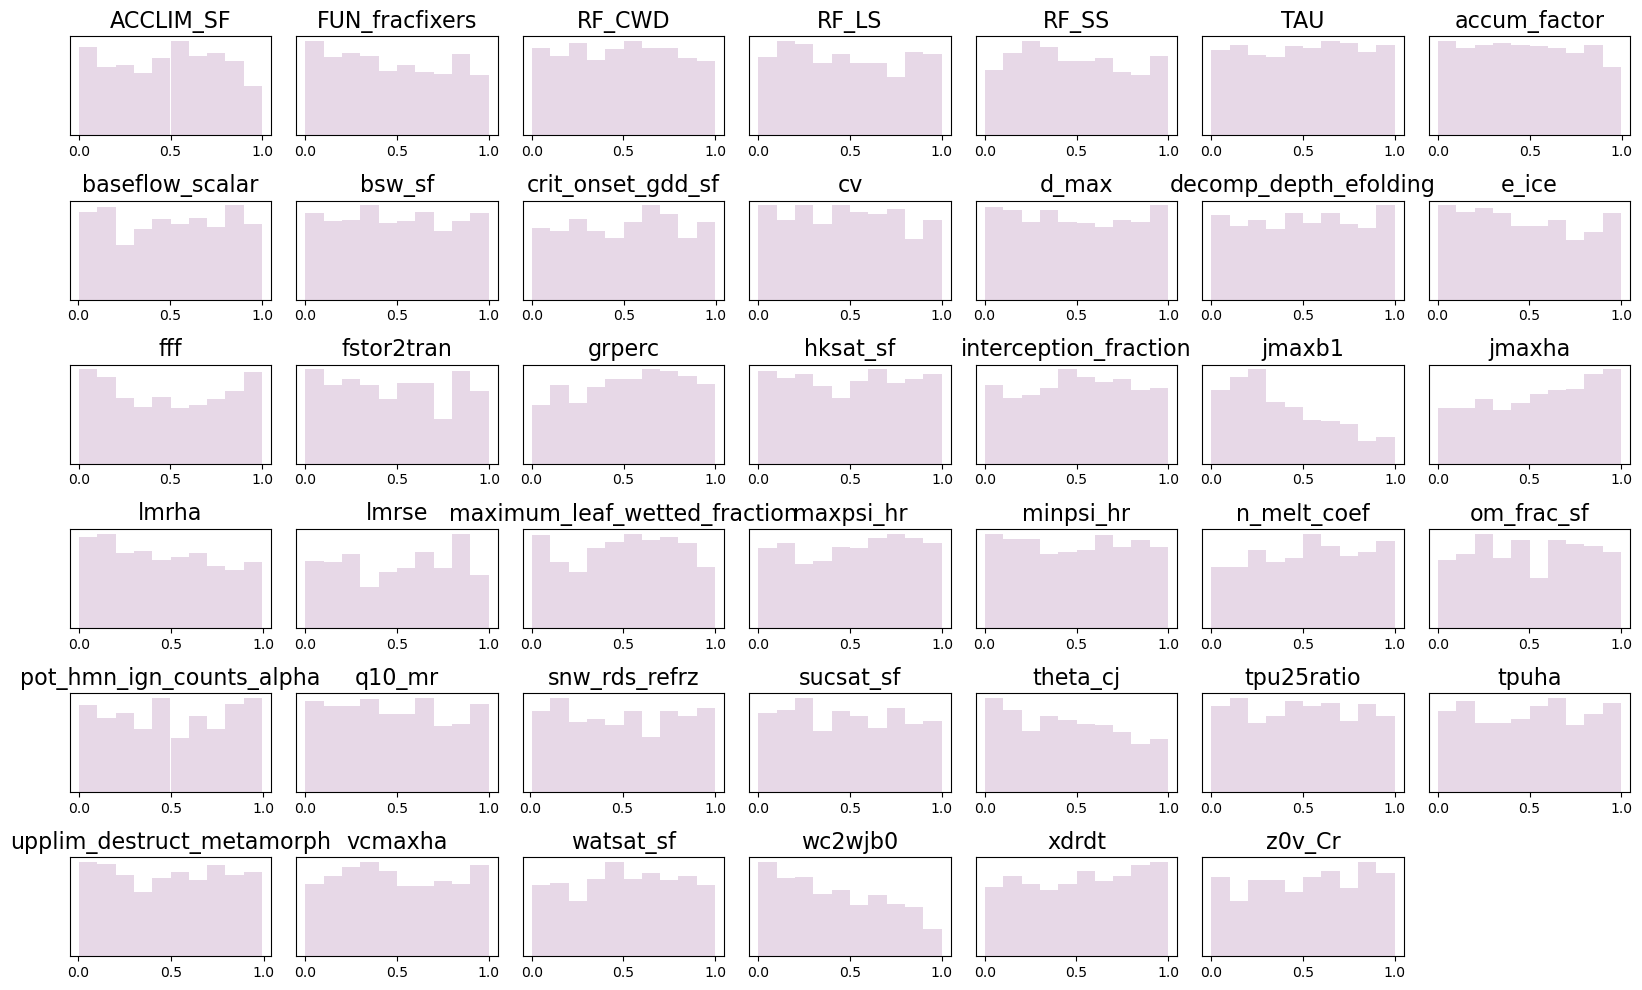

In [14]:
# plot posteriors

# Universal samples 
plt.figure(figsize=[16,10])
p = 1
samp = selected_paramsets.nroy_paramsets.sel(pft=1).values
d1 = pd.DataFrame(samp,columns = params.columns)

for i,param in enumerate(u_params):
    plt.subplot(6,7,i+1)
    plt.hist(d1[param],density=True,color='thistle',alpha=0.6)

    #sns.kdeplot(d1[param], fill=True,color='thistle', alpha=0.6)
    #plt.xticks([])
    plt.yticks([])
    plt.title(param,fontsize=16)
plt.tight_layout()
plt.savefig('./figs/wave1_posteriors_uparams_hist.png',dpi=100)

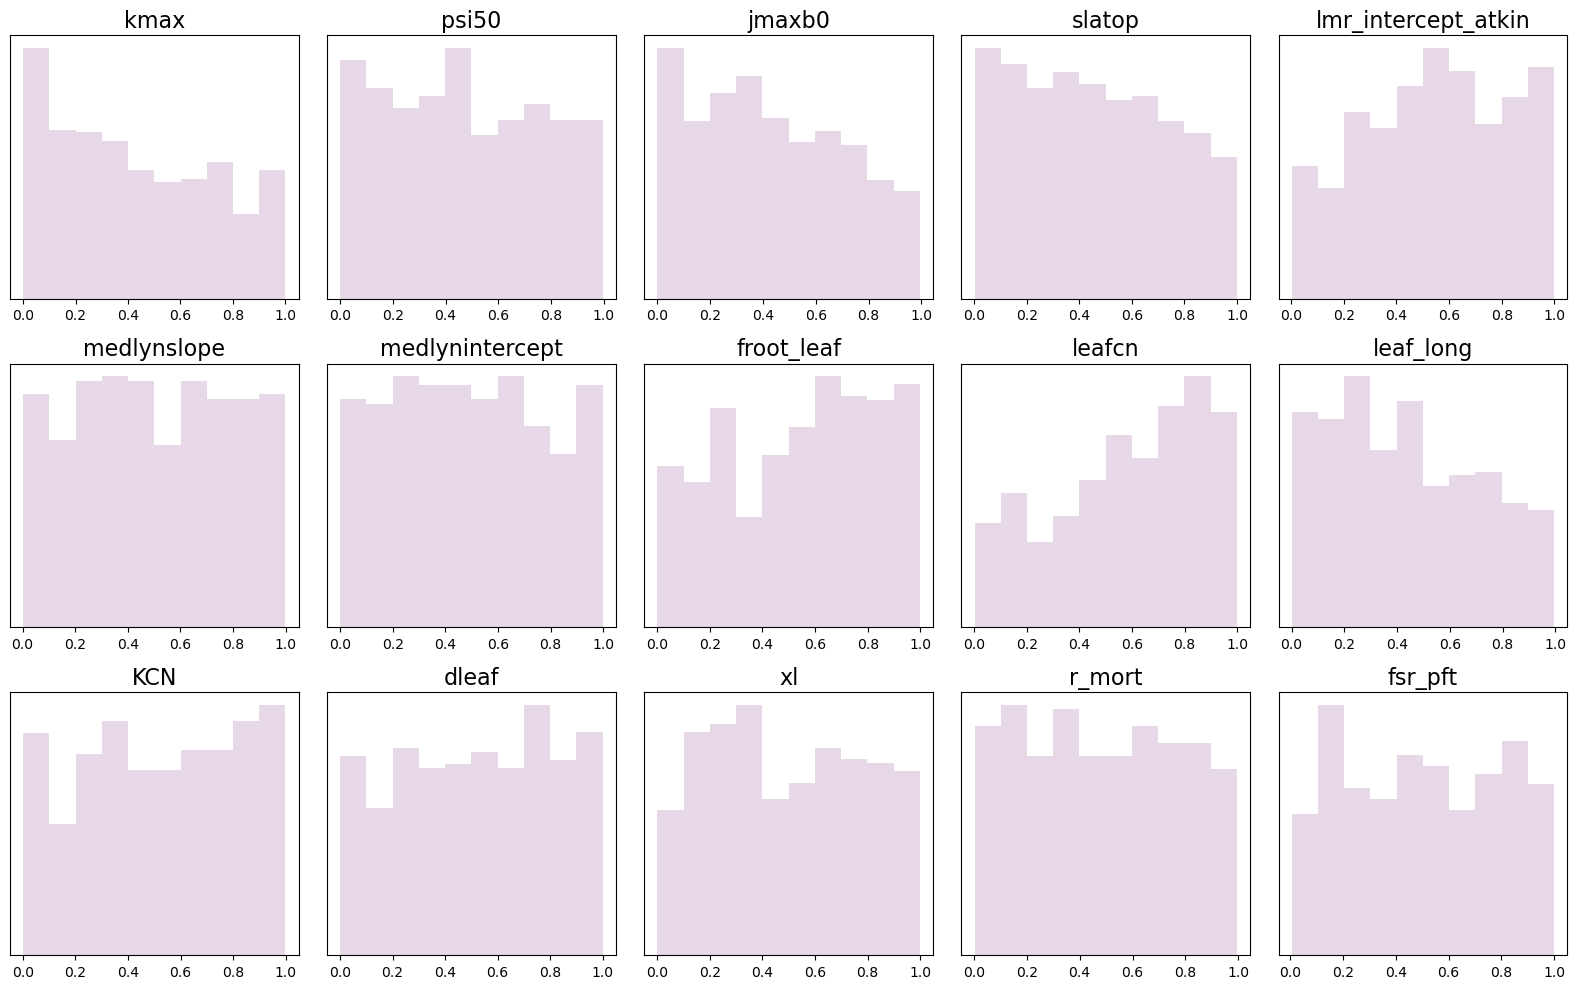

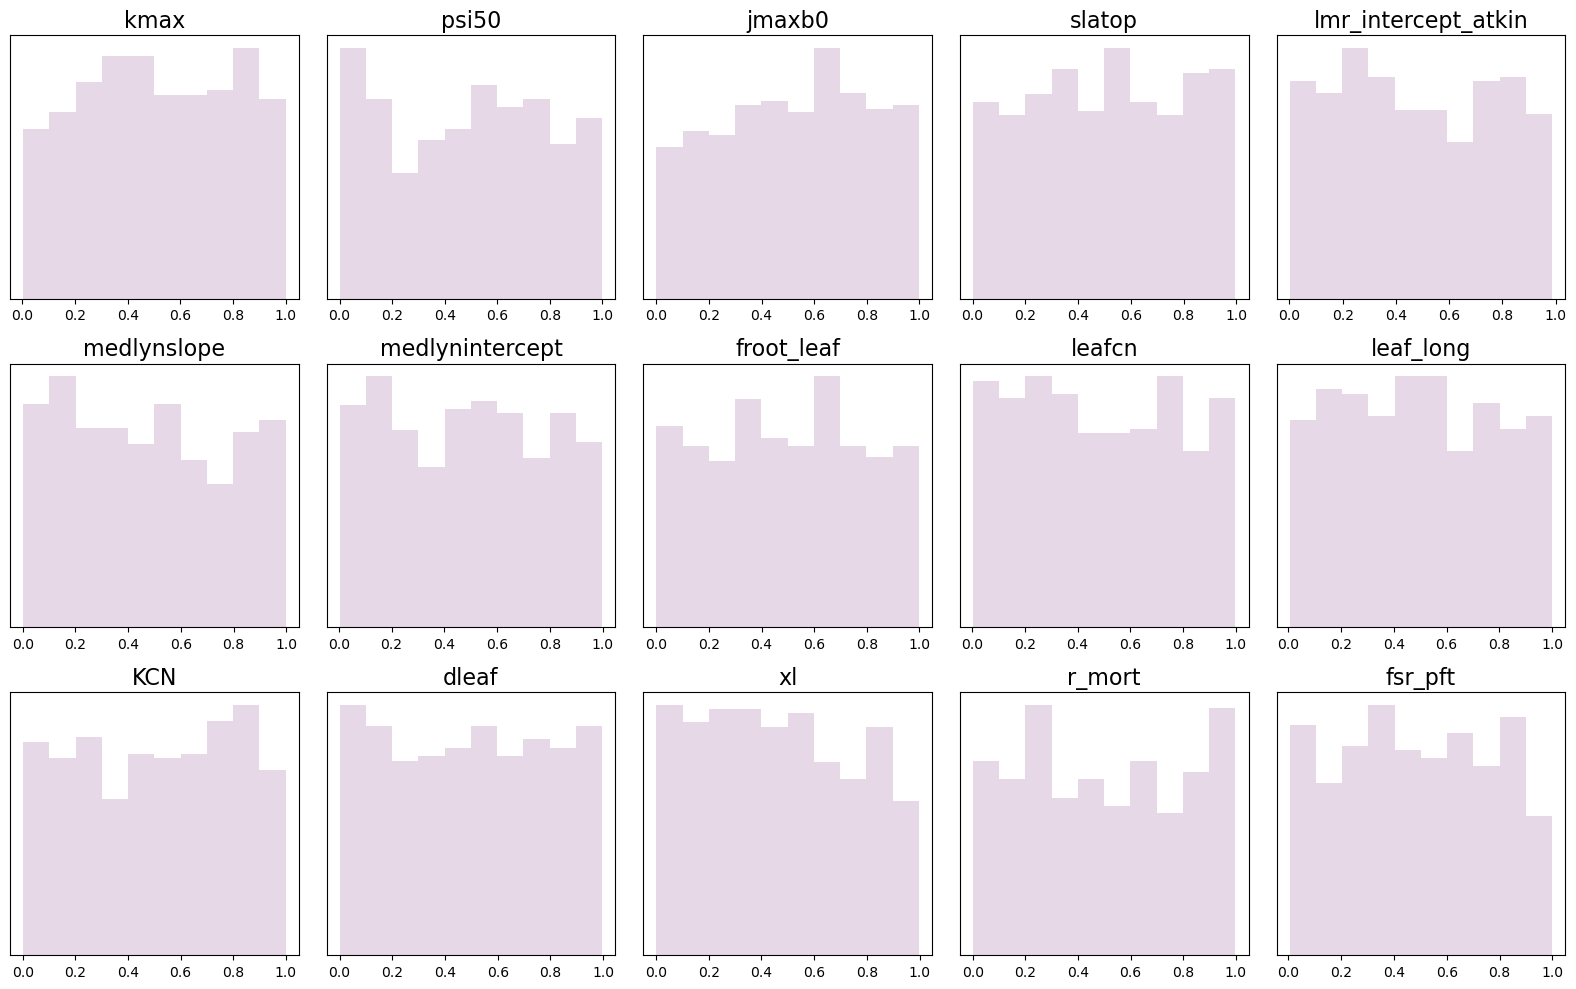

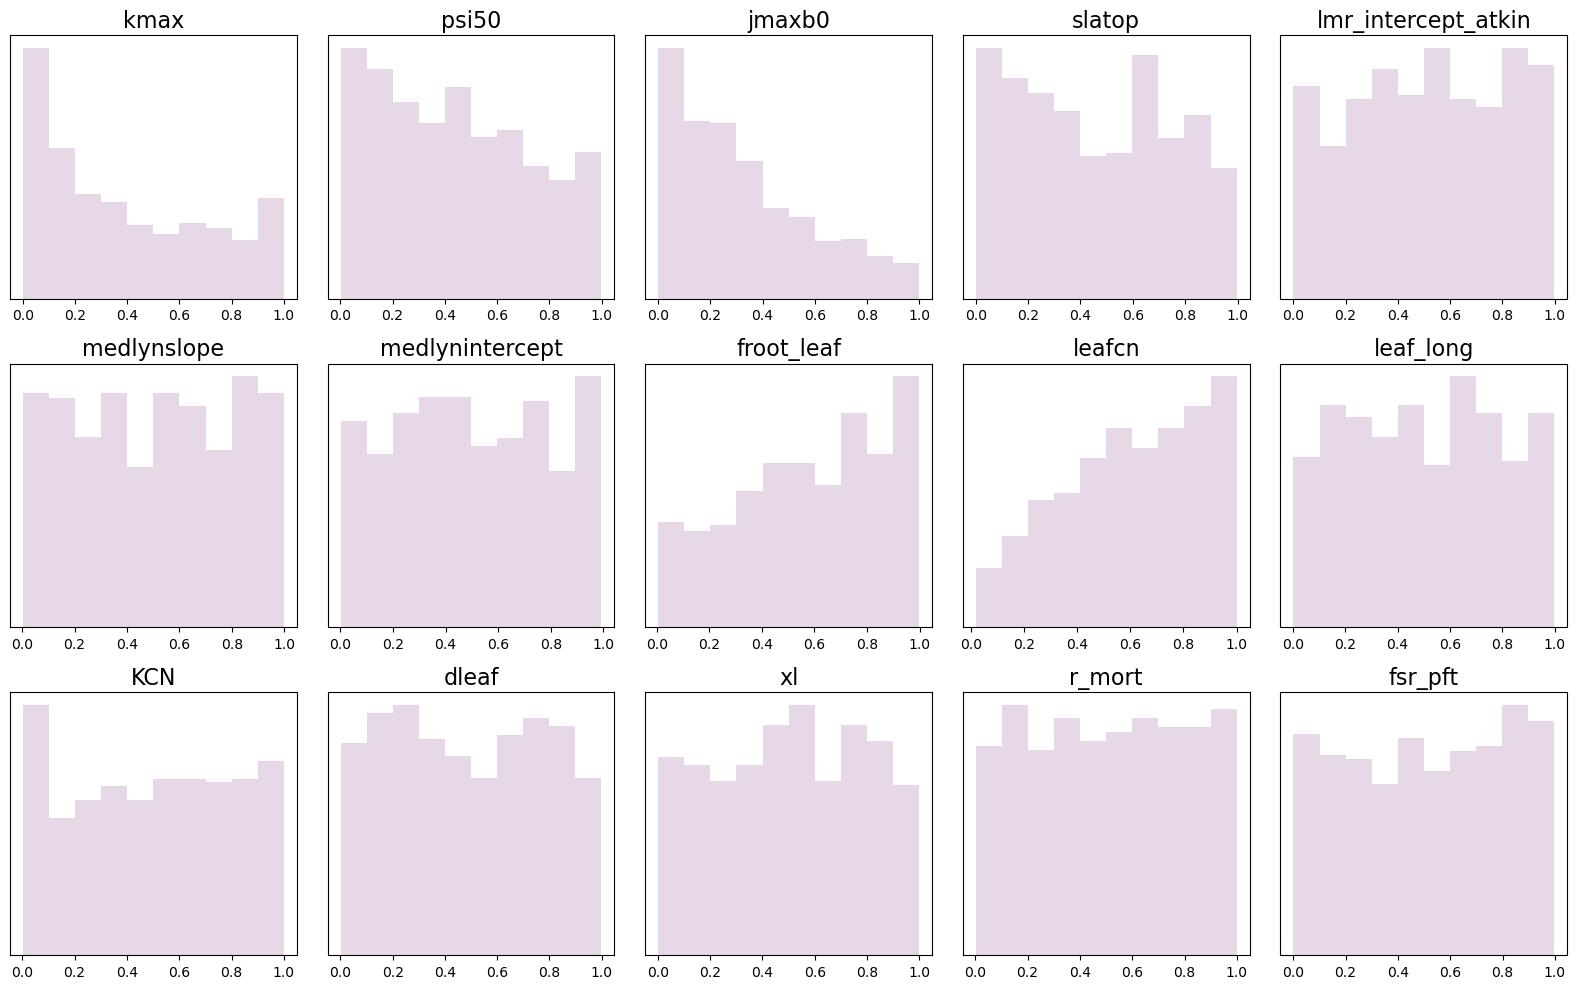

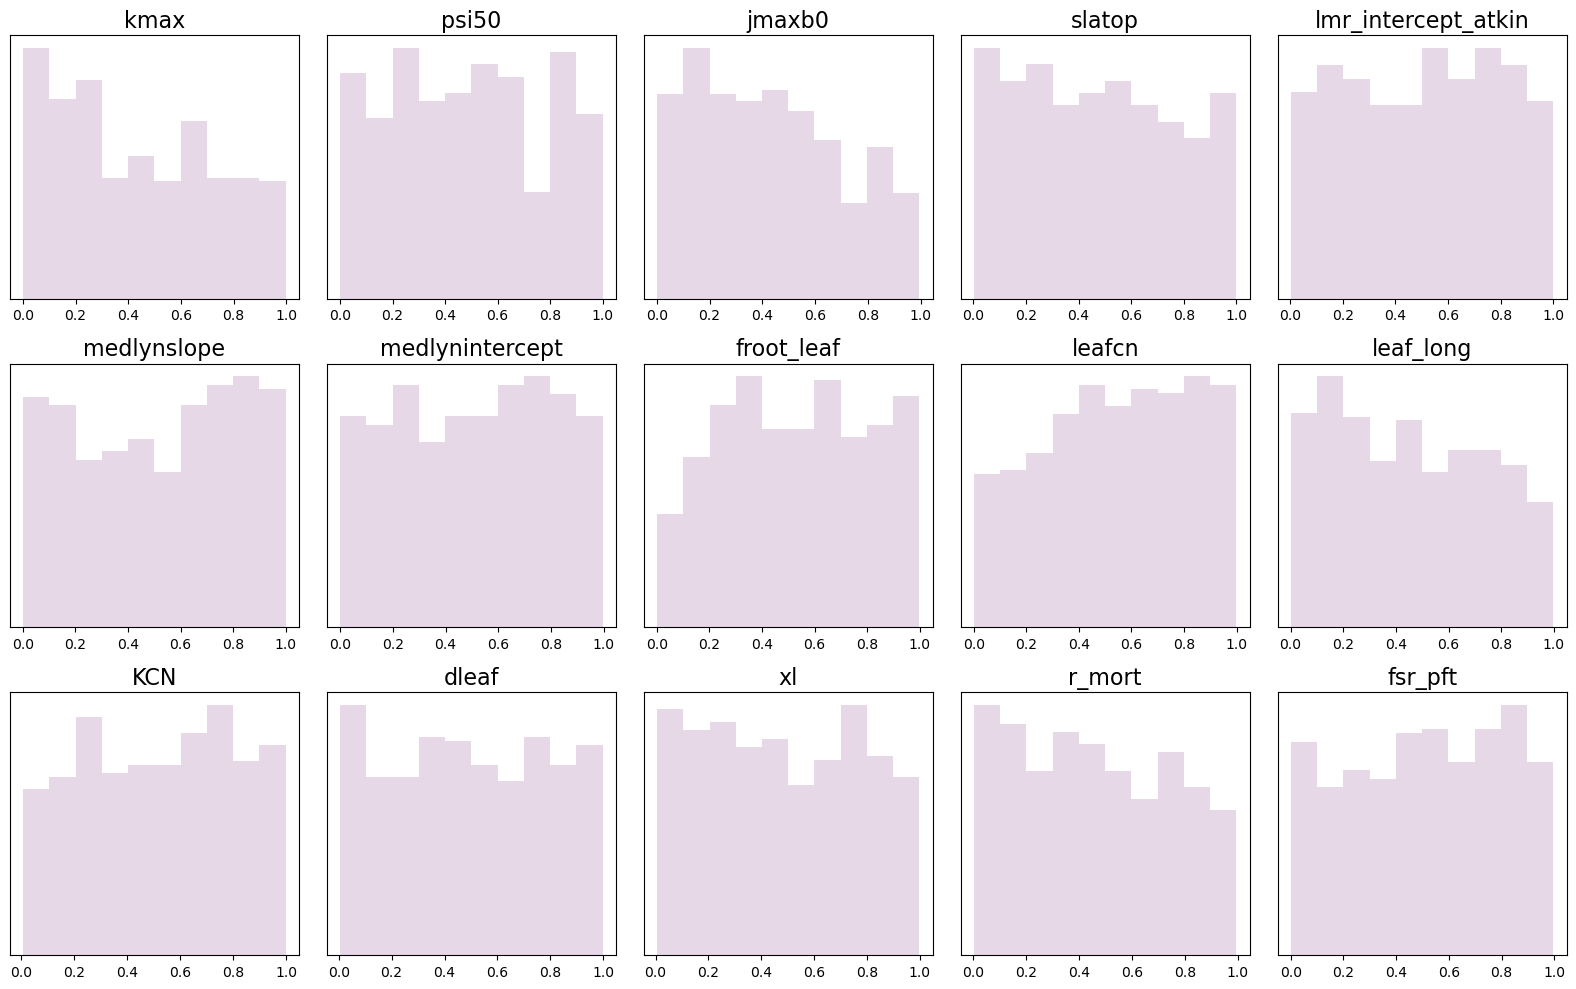

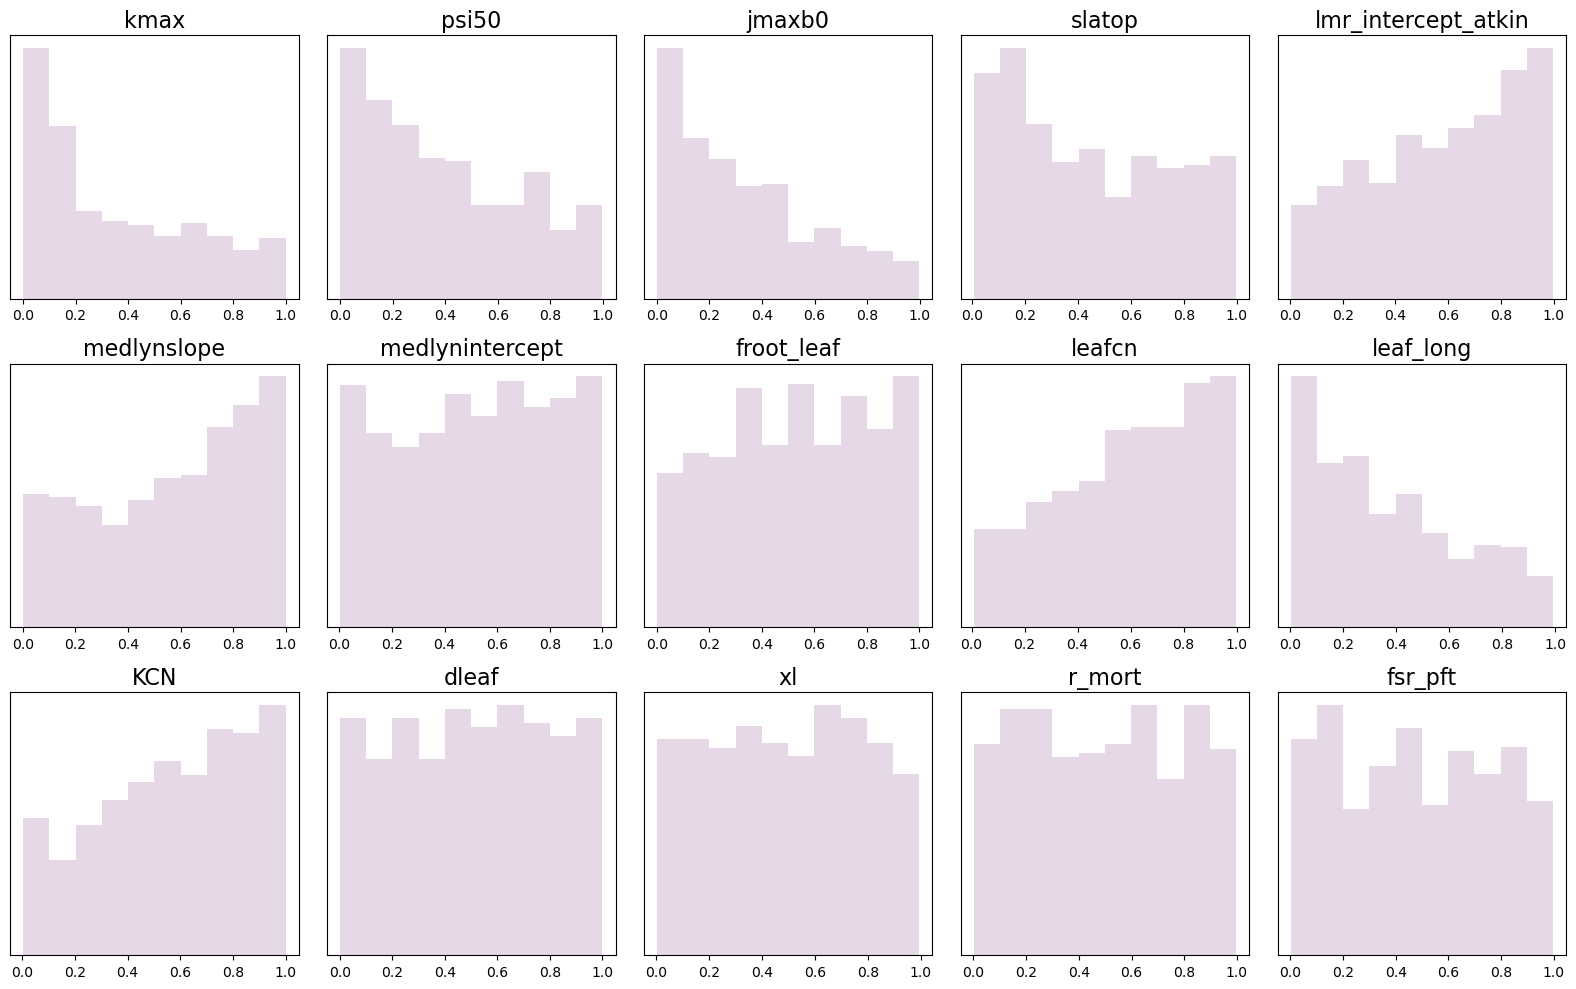

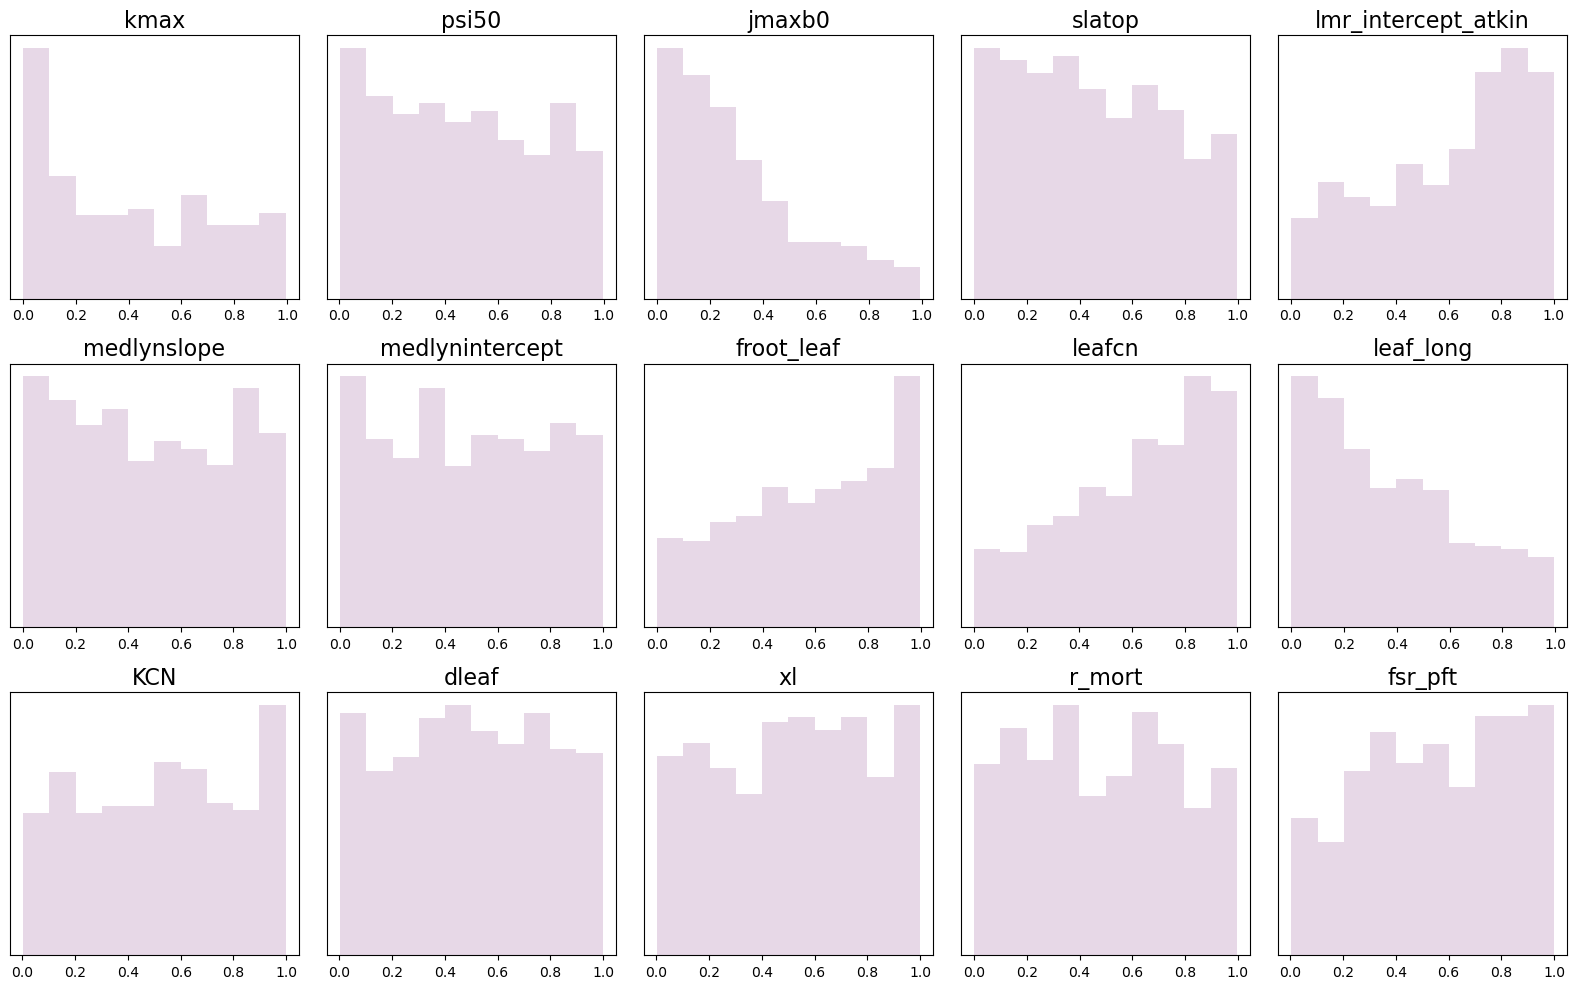

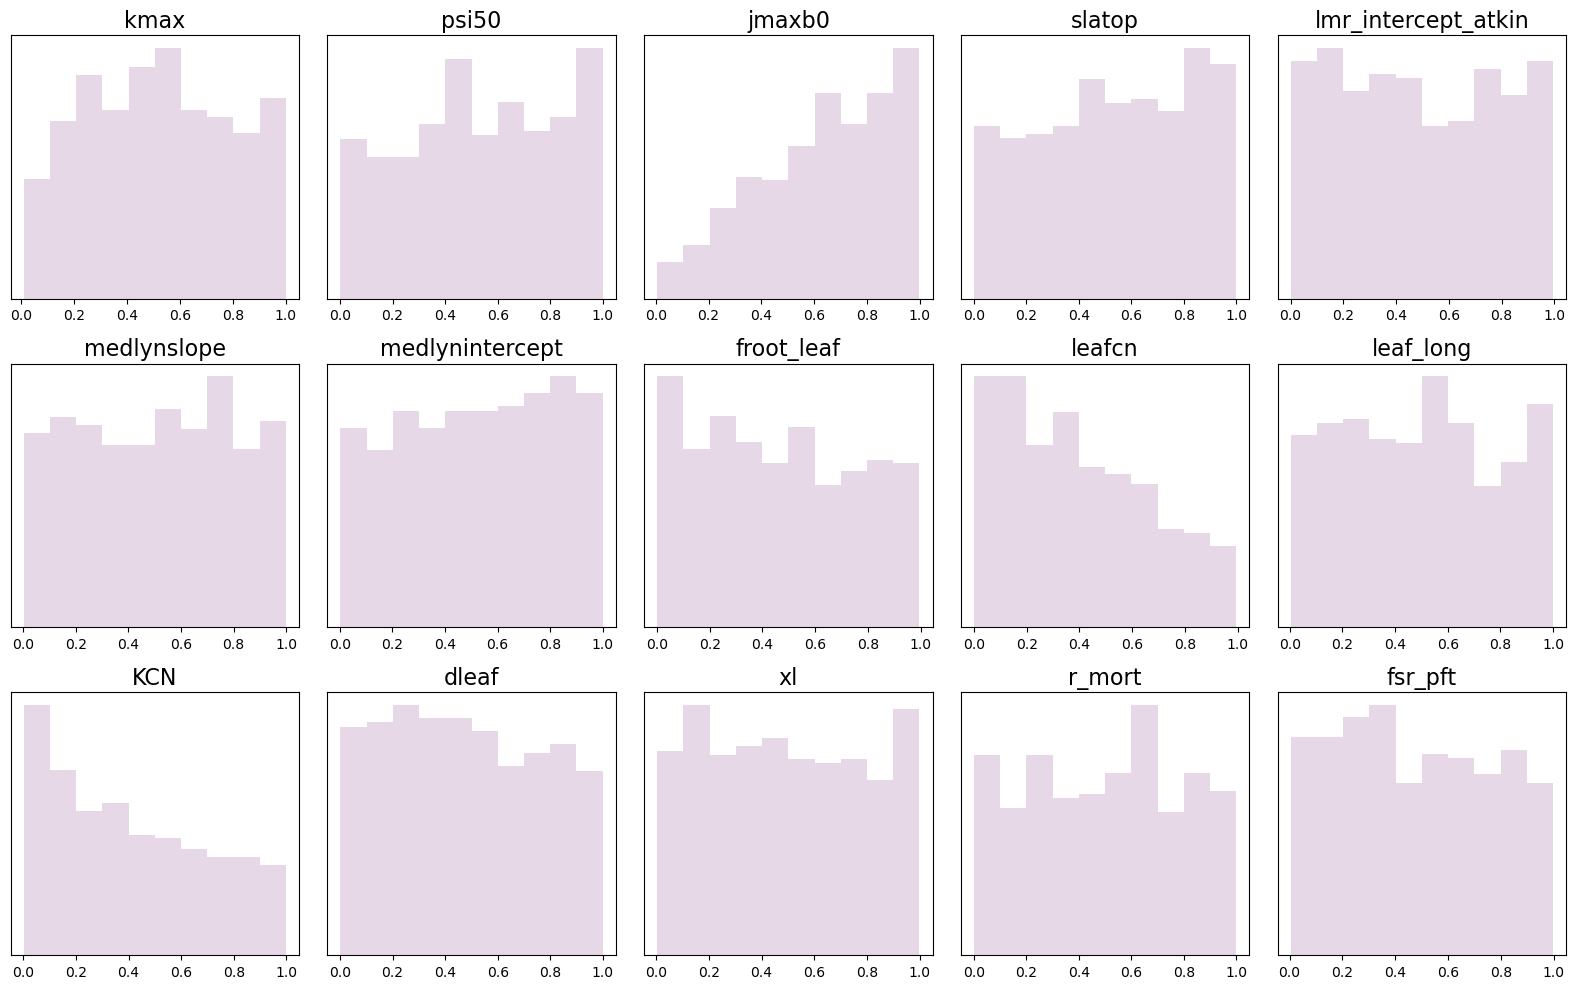

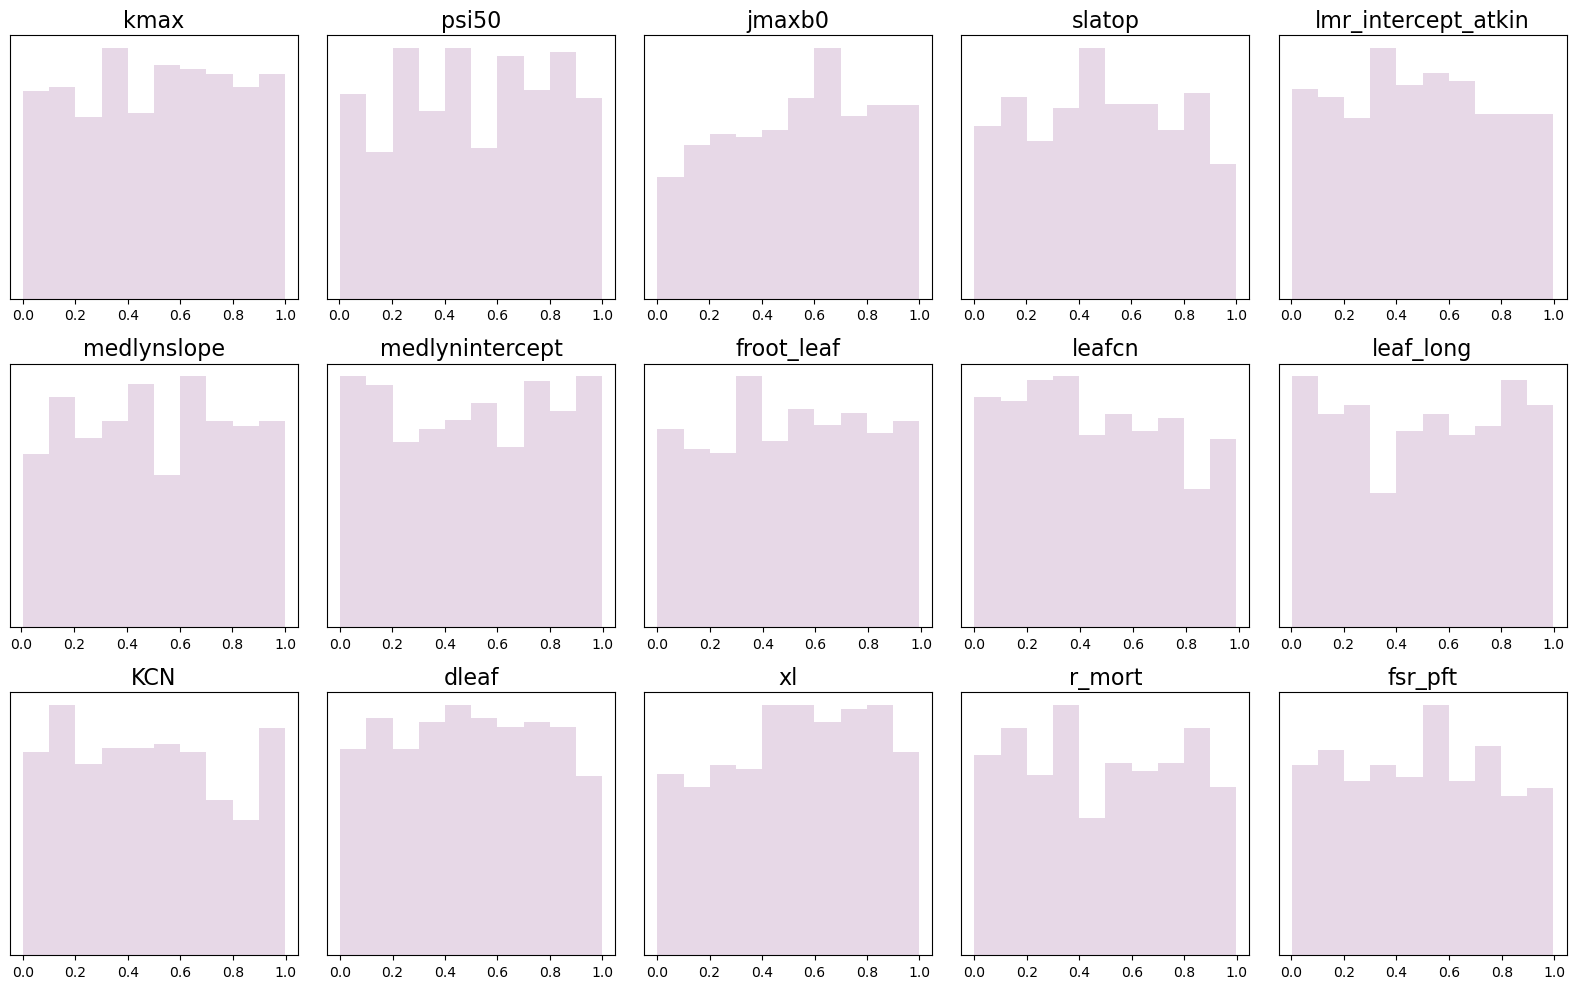

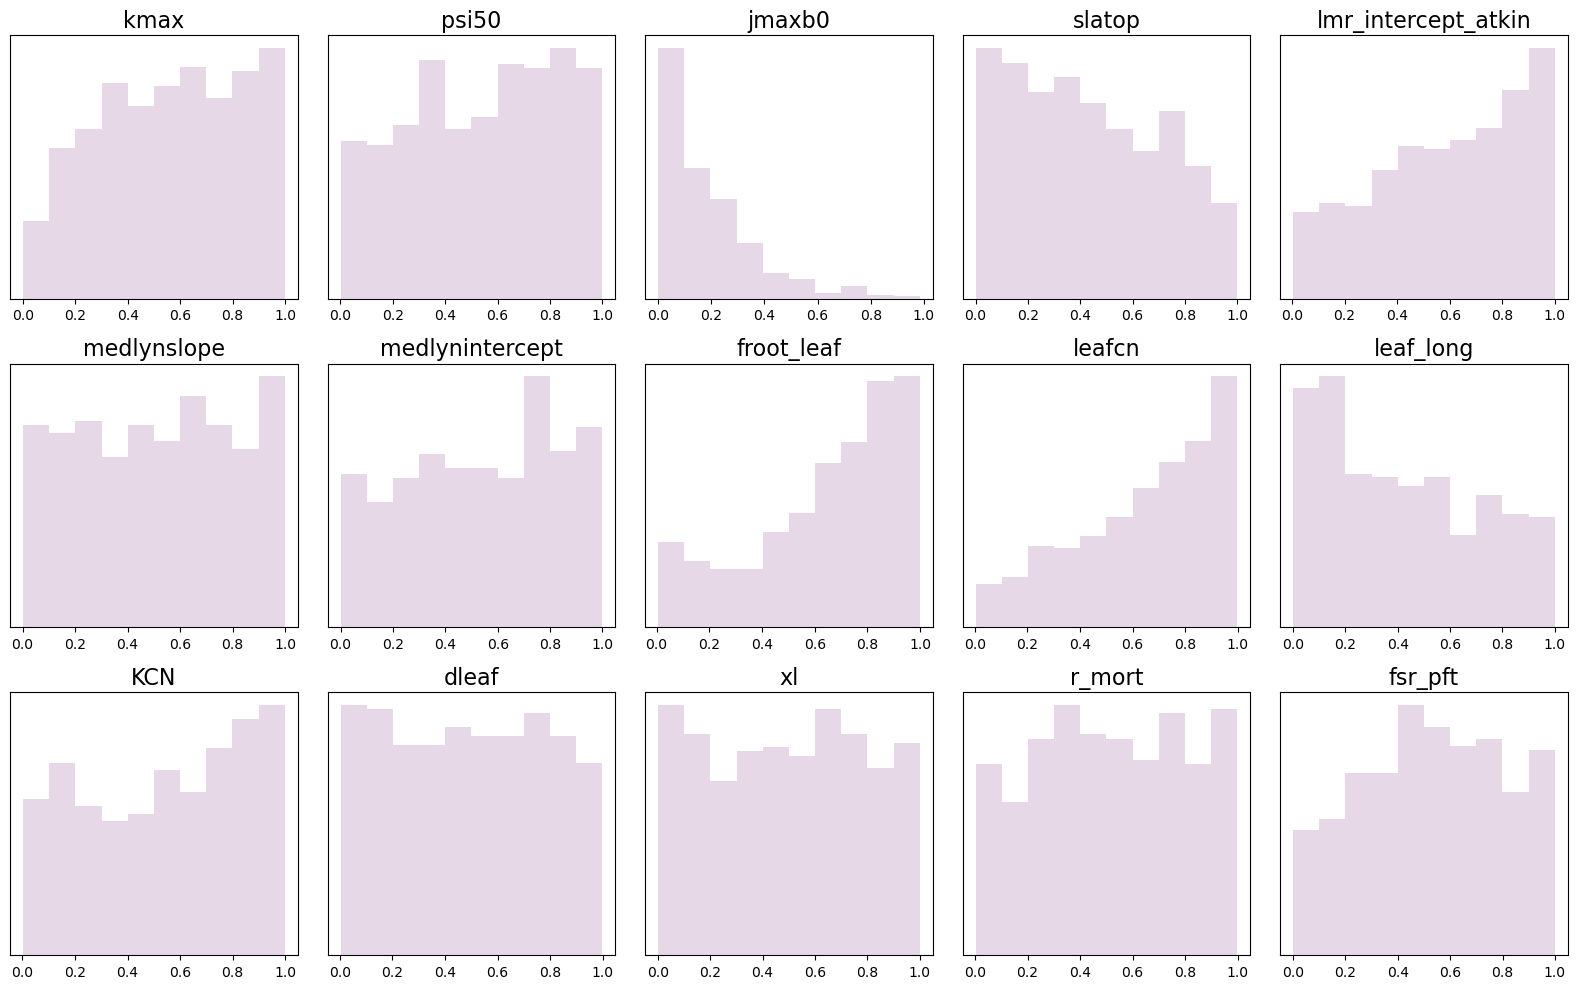

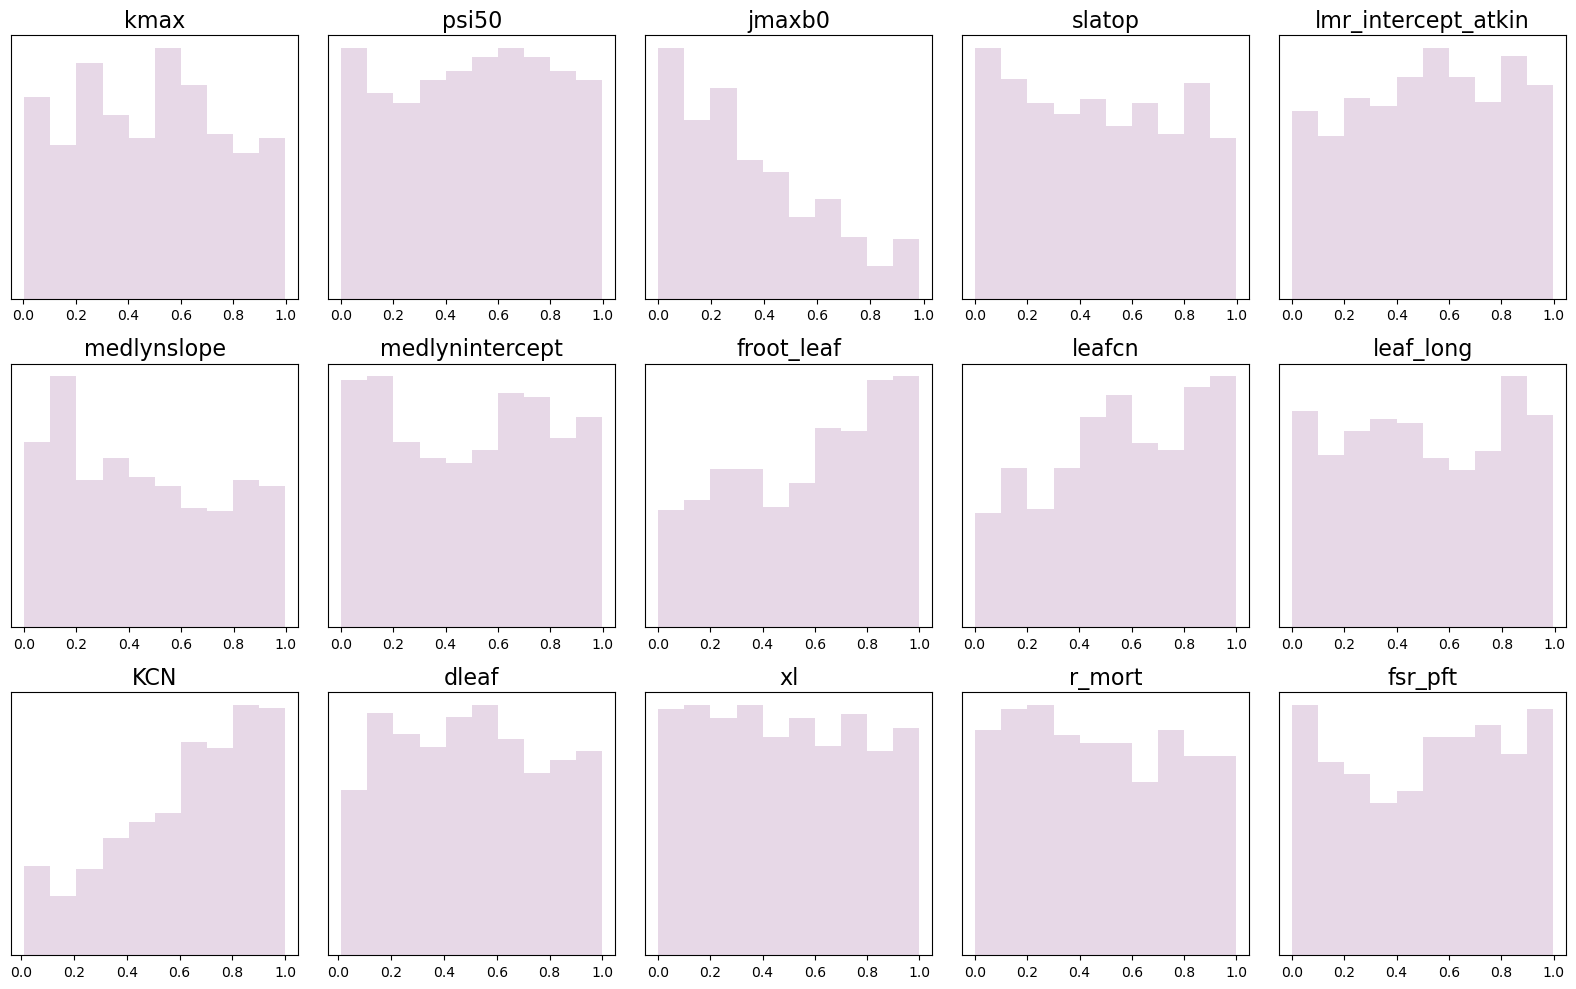

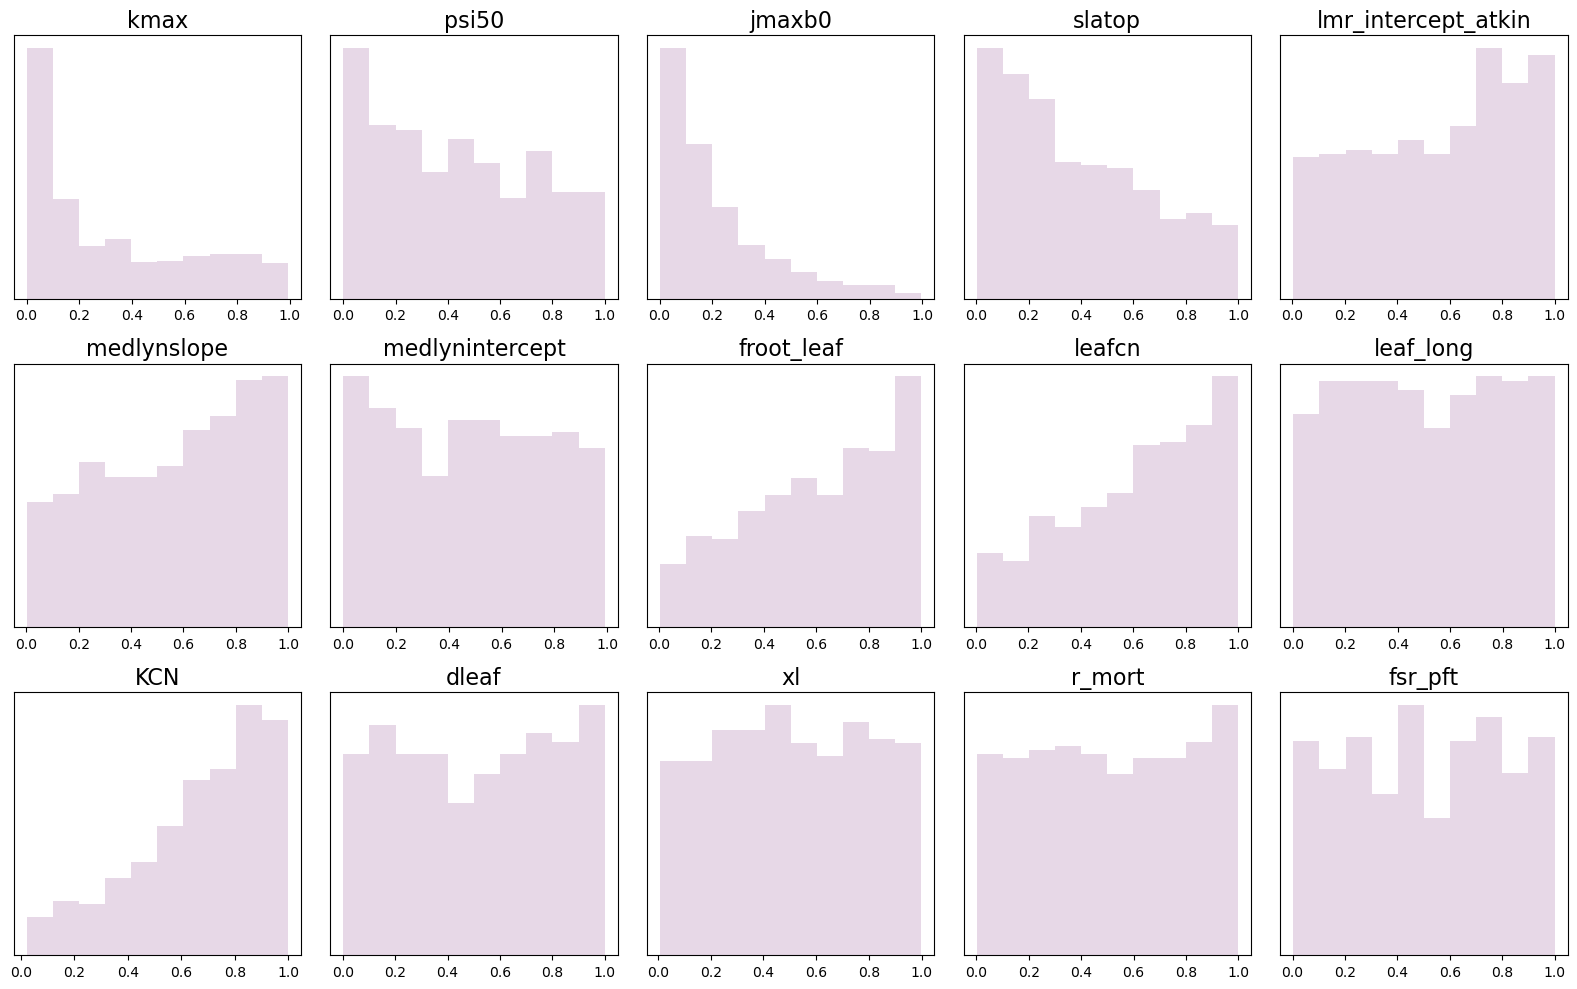

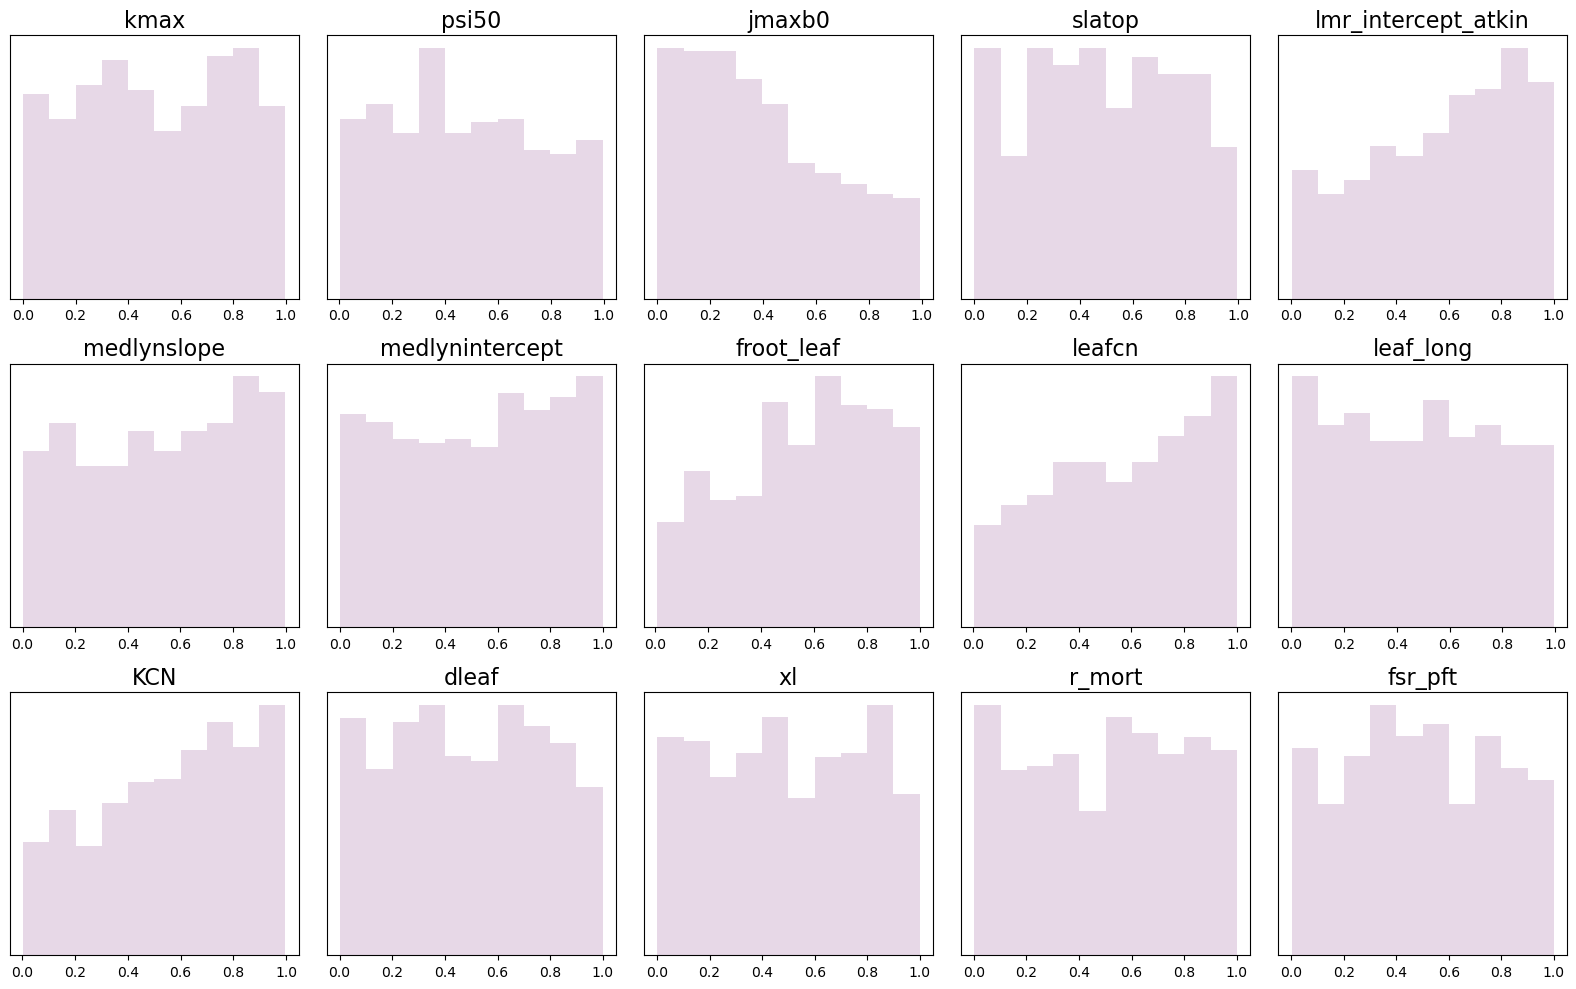

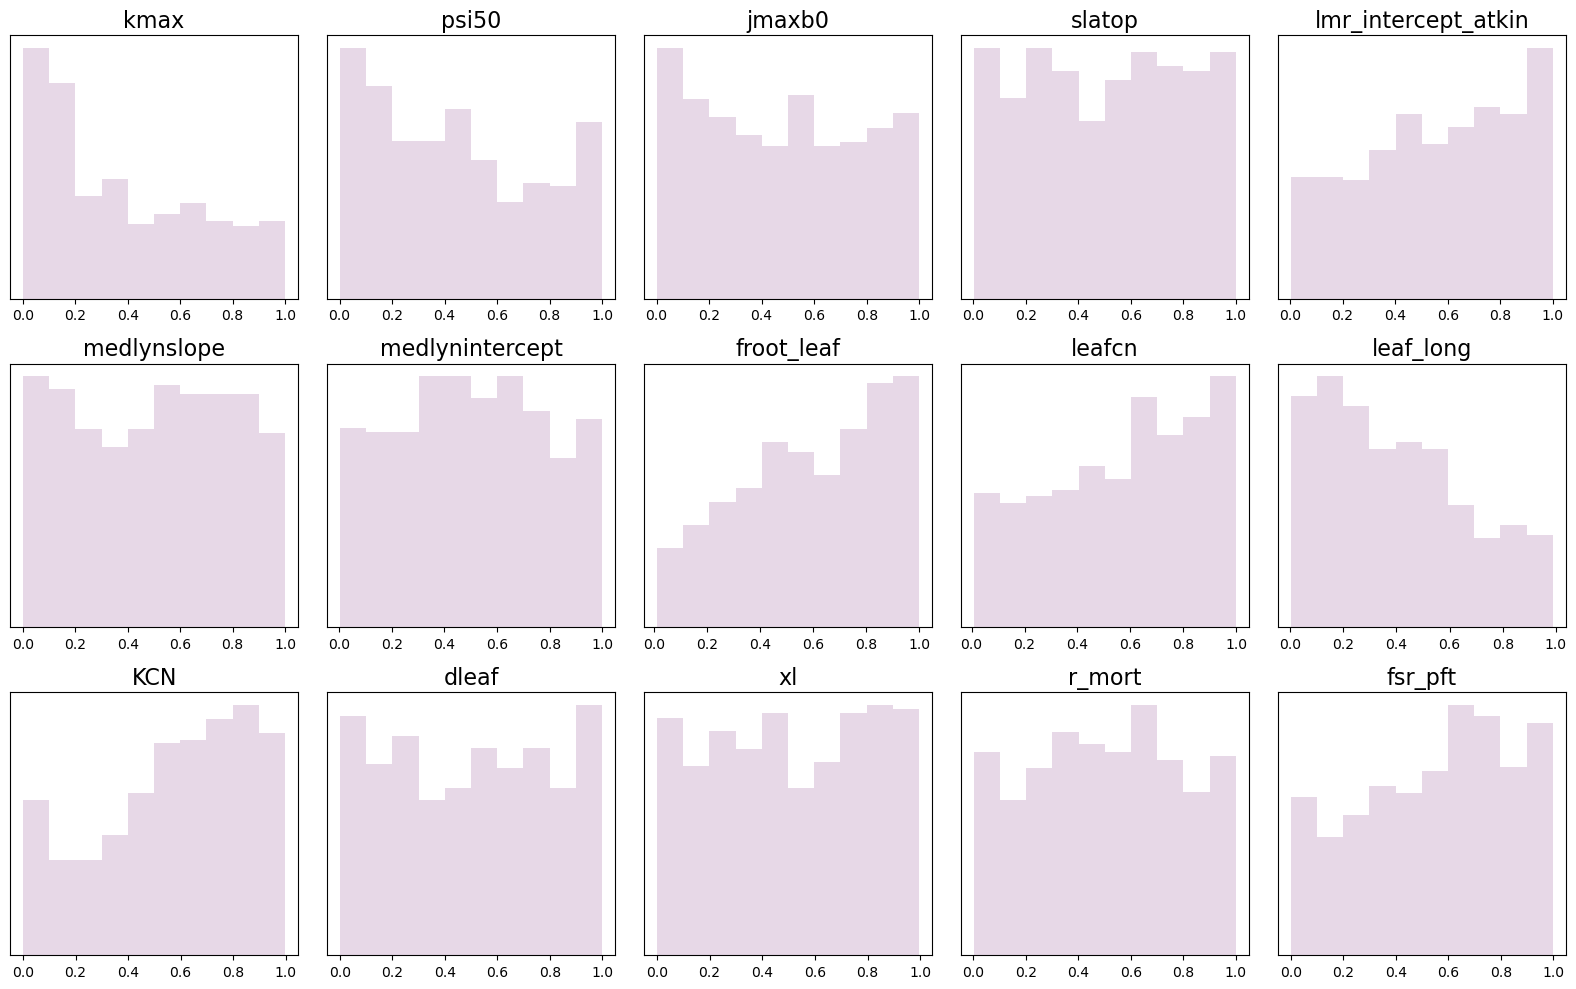

In [15]:
# pft param posteriors
for p in pft_ids:
    plt.figure(figsize=[16,10])
    samp = selected_paramsets.nroy_paramsets.sel(pft=p).values
    d1 = pd.DataFrame(samp,columns = params.columns)
    
    for i,param in enumerate(pft_params):
        plt.subplot(3,5,i+1)
    
        #sns.kdeplot(d1[param], fill=True,color='thistle', alpha=0.4)
        plt.hist(d1[param],density=True,color='thistle',alpha=0.6)
    
        plt.yticks([])
        plt.title(param,fontsize=16)
    plt.tight_layout()
    plt.savefig('./figs/wave1_posteriors_PFTparams_pft'+str(pft)+'.png')